# Implémentez un modèle de scoring

In [1]:
# !pip install pycaret

In [2]:
# !pip install bokeh

In [3]:
#! pip install xgboost

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support
import xgboost as xgb


In [5]:
appTest = pd.read_csv("zip/application_test.csv")
appTrain = pd.read_csv("zip/application_train.csv")
bureau = pd.read_csv("zip/bureau.csv")
bureauBal = pd.read_csv("zip/bureau_balance.csv")
creditCardBal = pd.read_csv("zip/credit_card_balance.csv")
homeCredit = pd.read_csv("zip/HomeCredit_columns_description.csv")
installmentsP = pd.read_csv("zip/installments_payments.csv")
POS_CASH_B = pd.read_csv("zip/POS_CASH_balance.csv")
previous_Apps = pd.read_csv("zip/previous_application.csv")
sample_sub = pd.read_csv("zip/sample_submission.csv")

In [6]:
# Reduce Memory Usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
def Description(Status=""):
    dire = homeCredit.loc[homeCredit["Row"]==Status,]["Description"]
    print(dire.values)
    return dire
    

In [8]:
def colNul(df, nulle = 0):
    print(df.loc[:,(df.isna().sum() == nulle).values])
    return list(df.loc[:,(df.isna().sum() == nulle).values].columns)

In [9]:
appTest = reduce_mem_usage(appTest) 
appTrain = reduce_mem_usage(appTrain)
bureau = reduce_mem_usage(bureau) 
bureauBal = reduce_mem_usage(bureauBal) 
creditCardBal = reduce_mem_usage(creditCardBal) 
homeCredit = reduce_mem_usage(homeCredit) 
installmentsP = reduce_mem_usage(installmentsP) 
POS_CASH_B = reduce_mem_usage(POS_CASH_B) 
previous_Apps = reduce_mem_usage(previous_Apps) 
sample_sub = reduce_mem_usage(sample_sub) 

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by -55.3%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
Memory usage of dataframe is 0.74 MB
Memory usage after optimization is:

In [10]:
appTrain.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

# Analyse univariée

In [11]:
appTrain["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [12]:
appTrain["TARGET"].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

92% des prêts sont accordés ne débouchent pas sur un défaut de paiement ou dis autrement 8% des prêts font un défaut.

In [13]:
revenus = appTrain.groupby(by="CODE_GENDER")["AMT_INCOME_TOTAL"].mean()

In [14]:
revenus

CODE_GENDER
F      156032.312500
M      193396.484375
XNA    186750.000000
Name: AMT_INCOME_TOTAL, dtype: float32

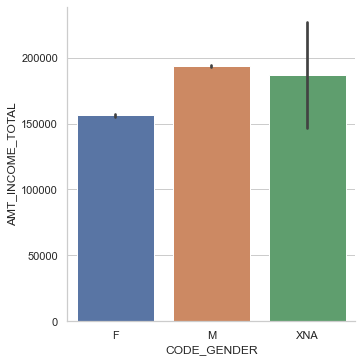

In [15]:
sns.catplot(x="CODE_GENDER", y="AMT_INCOME_TOTAL",kind="bar", data=appTrain)

Les personnes de sex masculin gagnent plus que les autres

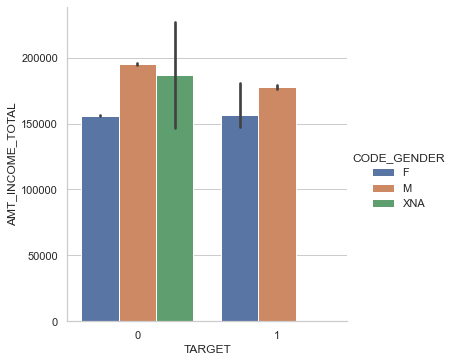

In [16]:
sns.catplot(x="TARGET", y="AMT_INCOME_TOTAL",kind="bar", hue="CODE_GENDER" ,data=appTrain)

Le salaire ne semble pas être un facteur important de défaut de paiement. Nous voyons que les femmes en défaut de paiement gagnent en moyenne plus que les femmes en non défaut de paiement. En revanche les hommes en défaut de paiement gagnent moins, un peu moins

In [17]:
appTrain["CODE_GENDER"].value_counts(normalize=True)

F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64

Les femmes constituent 66% du dataset

In [18]:
appTrain["CODE_GENDER"].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [19]:
appTrain[appTrain["TARGET"]==1]["CODE_GENDER"].value_counts()

F      14170
M      10655
XNA        0
Name: CODE_GENDER, dtype: int64

In [20]:
appTrain["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [21]:
appTrain[appTrain["TARGET"]==1]["CODE_GENDER"].value_counts()/appTrain["CODE_GENDER"].value_counts()

F      0.069993
M      0.101419
XNA    0.000000
Name: CODE_GENDER, dtype: float64

Ramener à la proportion du genre, 10% des hommes sont en défaut de paiement et 6% des femmes.

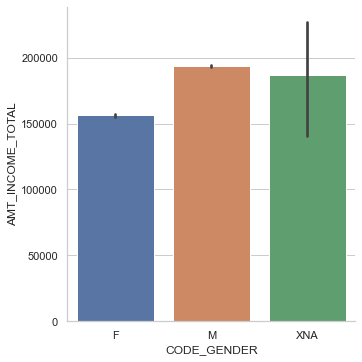

In [22]:
sns.catplot(x="CODE_GENDER", y="AMT_INCOME_TOTAL",kind="bar", data=appTrain)

In [23]:
# homeCredit["Description"].str.contains('id', flags=re.IGNORECASE, regex=True).sum()

In [24]:
# aa = Description("CODE_GENDER")

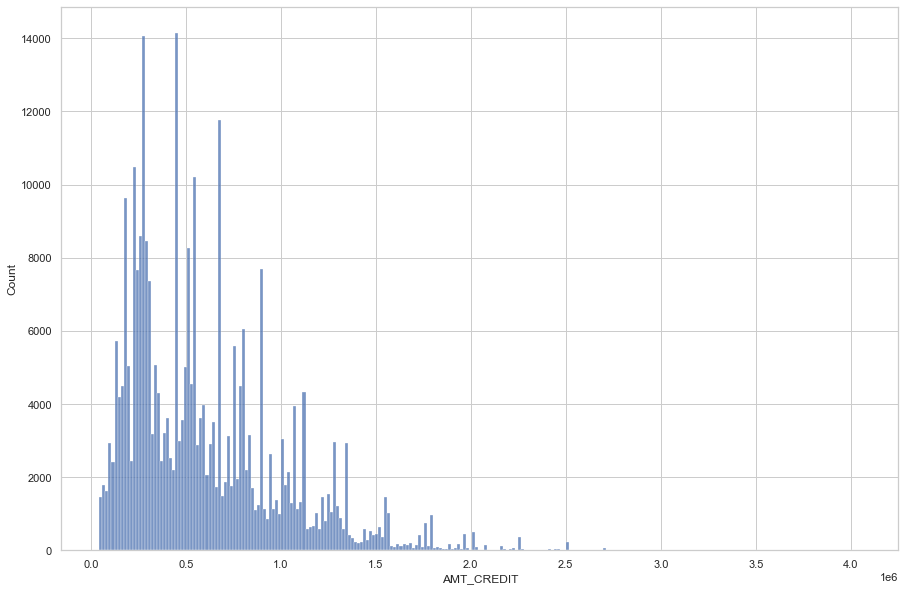

In [25]:
plt.figure(figsize=(15,10))
sns.histplot(data=appTrain, x="AMT_CREDIT")
plt.show()

In [26]:
appTrain

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.000000,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborer

In [27]:
Description("NAME_CONTRACT_TYPE")

['Identification if loan is cash or revolving', 'Contract product type (Cash loan, consumer lo...]
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


2            Identification if loan is cash or revolving
175    Contract product type (Cash loan, consumer loa...
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

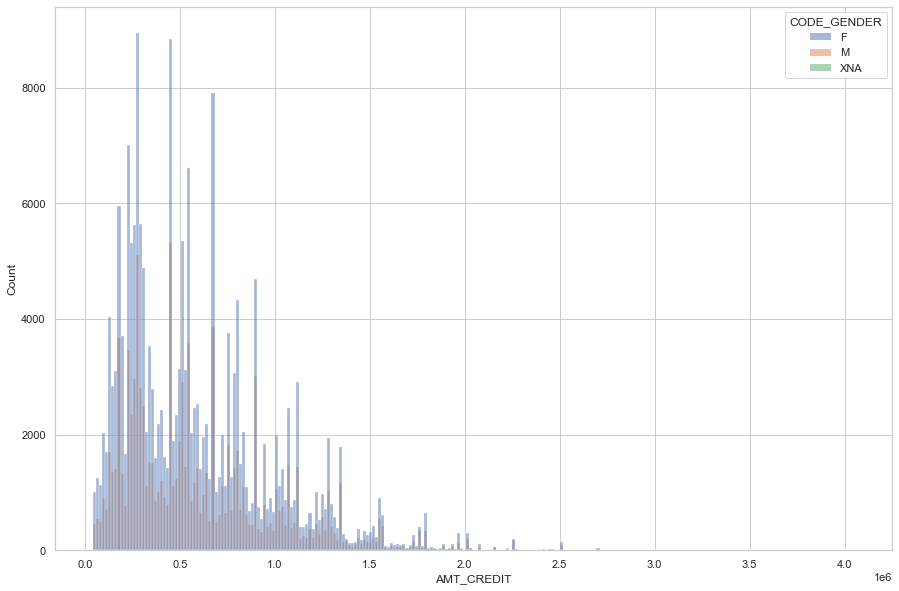

In [28]:
plt.figure(figsize=(15,10))
sns.histplot(data=appTrain, x="AMT_CREDIT", hue='CODE_GENDER')
plt.show()

In [29]:
print(pd.crosstab(appTrain['NAME_CONTRACT_TYPE'], appTrain['TARGET'], margins = True))

TARGET                   0      1     All
NAME_CONTRACT_TYPE                       
Cash loans          255011  23221  278232
Revolving loans      27675   1604   29279
All                 282686  24825  307511


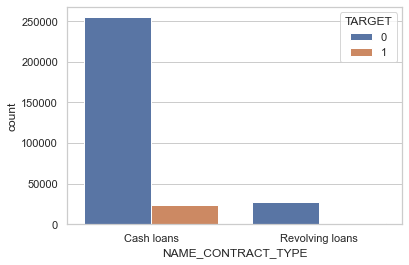

In [30]:
ax = sns.countplot(x="NAME_CONTRACT_TYPE", hue="TARGET", data=appTrain)

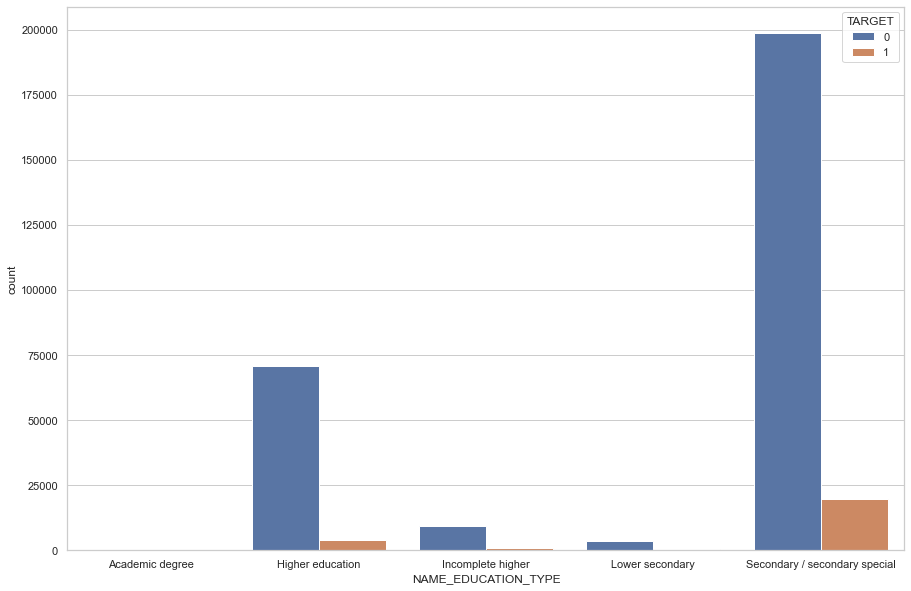

In [31]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_EDUCATION_TYPE", hue="TARGET", data=appTrain)

In [32]:
appTrain["credSURrevenu"] = appTrain["AMT_CREDIT"]/appTrain["AMT_INCOME_TOTAL"]

In [33]:
appTrain["annuitySURrevenu"] = appTrain["AMT_ANNUITY"]/appTrain["AMT_INCOME_TOTAL"]

In [34]:
appTrain

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,credSURrevenu,annuitySURrevenu
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.007889,0.121978
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.000000,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.790750,0.132217
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / ap

In [35]:
Description("OCCUPATION_TYPE")

['What kind of occupation does the client have']
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


28    What kind of occupation does the client have
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [36]:
print(pd.crosstab(appTrain['NAME_FAMILY_STATUS'], appTrain['TARGET'],
              values=appTrain['credSURrevenu'], aggfunc='mean'))

TARGET                       0         1
NAME_FAMILY_STATUS                      
Civil marriage        3.498153  3.458186
Married               4.268384  4.195590
Separated             3.484925  3.492641
Single / not married  3.241925  3.254053
Unknown               2.194444       NaN
Widow                 3.662932  4.055566


In [37]:
print(pd.crosstab(appTrain['NAME_INCOME_TYPE'], appTrain['TARGET'],
              values=appTrain['credSURrevenu'], aggfunc='mean'))

TARGET                        0          1
NAME_INCOME_TYPE                          
Businessman            2.856667        NaN
Commercial associate   3.692696   3.590468
Maternity leave        3.875000  14.906061
Pensioner              4.389175   4.731382
State servant          4.163524   4.274287
Student                3.586951        NaN
Unemployed            12.658619  10.489530
Working                3.904396   3.790033


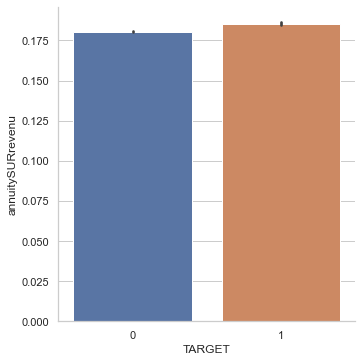

In [38]:
sns.catplot(x="TARGET", y="annuitySURrevenu",kind="bar", data=appTrain)

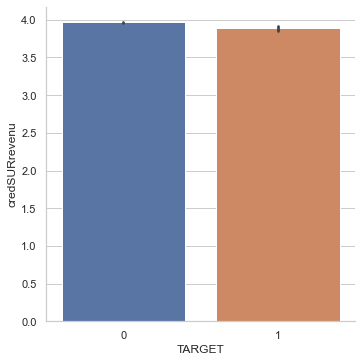

In [39]:
sns.catplot(x="TARGET", y="credSURrevenu",kind="bar", data=appTrain)

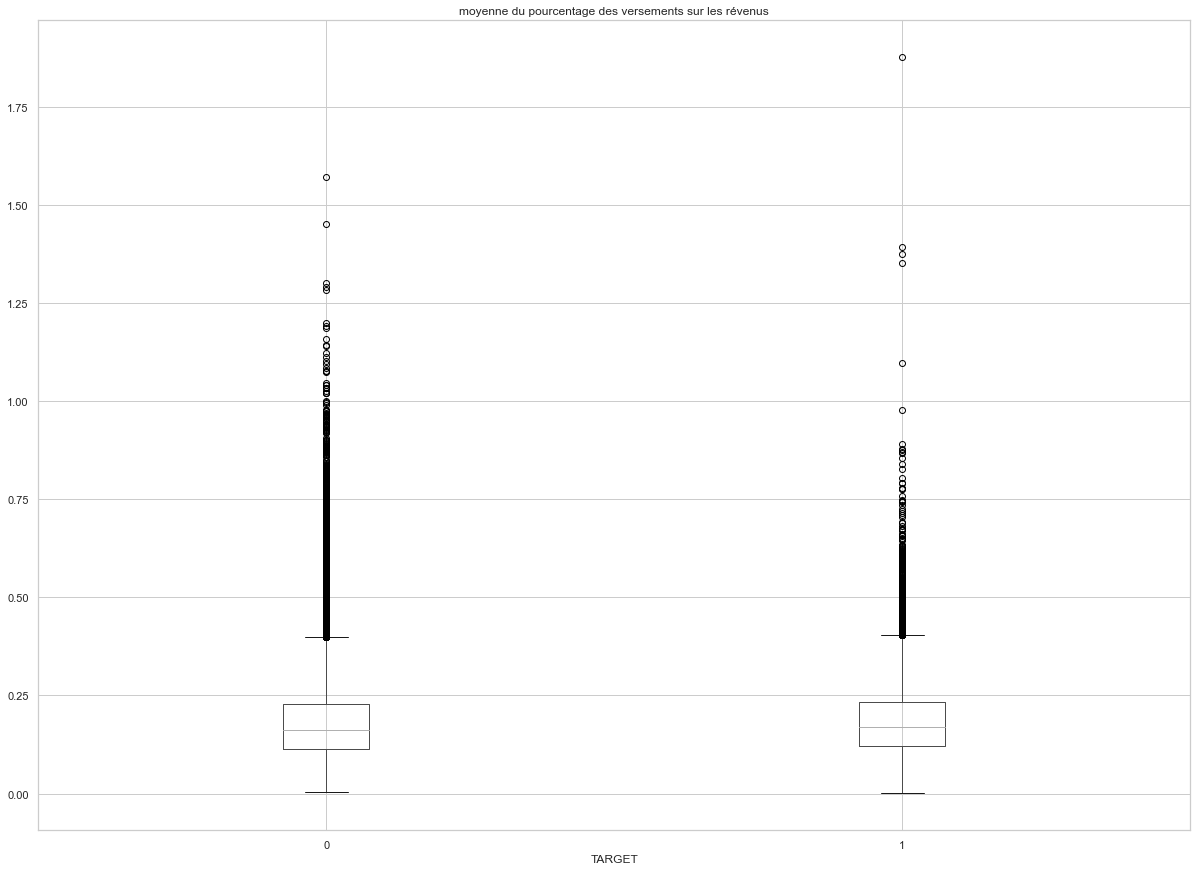

In [40]:
appTrain.boxplot(column = ['annuitySURrevenu'], by = 'TARGET', figsize=(20,15))
plt.title('moyenne du pourcentage des versements sur les révenus')
plt.suptitle('')
plt.show()

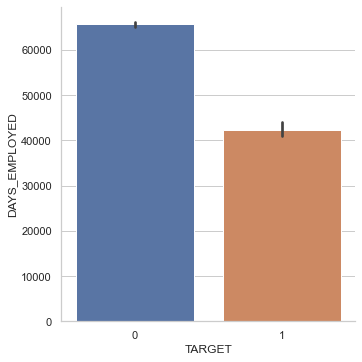

In [41]:

sns.catplot(x="TARGET", y="DAYS_EMPLOYED",kind="bar", data=appTrain)

In [42]:
appTrain.groupby(by="TARGET")["DAYS_EMPLOYED"].mean()

TARGET
0    65696.146123
1    42394.675448
Name: DAYS_EMPLOYED, dtype: float64

In [43]:
appTrain[appTrain["DAYS_EMPLOYED"]>50000]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,credSURrevenu,annuitySURrevenu
8,100011,0,Cash loans,F,N,Y,0,112500.00000,1019610.0,33826.5,913500.0,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.018631,-20099,365243,-7428.0,-3514,NaN,1,0,0,1,0,0,NaN,2.0,2,2,WEDNESDAY,14,0,0,0,0,0,0,XNA,0.587402,0.205688,0.751953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,9.063200,0.300680
11,100015,0,Cash loans,F,N,Y,0,38419.15625,148365.0,10678.5,135000.0,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.015221,-20417,365243,-5248.0,-2512,NaN,1,0,0,1,1,0,NaN,2.0,2,2,FRIDAY,7,0,0,0,0,0,0,XNA,0.722168,0.555176,0.652832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2396.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,3.861745,0.277947
23,100027,0,Cash loans,F,N,Y,0,83250.00000,239850.0,23850.0,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.006294,-24827,365243,-9008.0,-3684,NaN,1,0,0,1,1,0,NaN,2.0,3,3,FRIDAY,12,0,0,0,0,0,0,XNA,NaN,0.624512,0.668945,0.144287,0.084778,0.987793,0.830078,0.106384,0.140015,0.120728,0.375000,0.416748,0.237061,0.117310,0.148438,0.001900,0.000700,0.126099,0.075378,0.987793,0.836914,0.000000,0.120789,0.103394,0.375000,0.416748,0.242554,0.110229,0.092285,0.000000,0.000000,0.145752,0.084778,0.987793,0.832520,0.107117,0.140015,0.120728,0.375000,0.416748,0.241211,0.119324,0.151001,0.001900,0.000700,org spec account

In [44]:
dire = Description("DAYS_EMPLOYED")

['How many days before the application the pers...]
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


In [45]:
dire

18    How many days before the application the perso...
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [46]:
appTrain[appTrain["DAYS_EMPLOYED"]!=365243]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,credSURrevenu,annuitySURrevenu
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.007889,0.121978
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.000000,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.790750,0.132217
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / ap

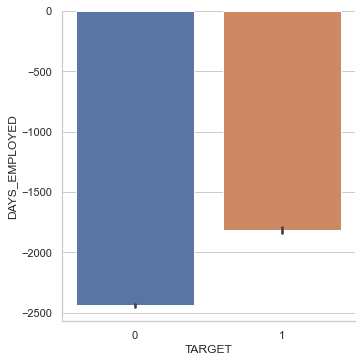

In [47]:
sns.catplot(x="TARGET", y="DAYS_EMPLOYED",kind="bar", data=appTrain[appTrain["DAYS_EMPLOYED"]!=365243])

365243 = XNA = NAN
Aussi de manière significatif, nous pouvons constater que le nombre de jour de salariat est en corrélation avec le défaut statut.

In [48]:
appTrain[appTrain["DAYS_EMPLOYED"]!=365243]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,credSURrevenu,annuitySURrevenu
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.007889,0.121978
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.000000,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.790750,0.132217
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / ap

In [49]:
moYappTrain = appTrain.copy()

In [50]:
moYappTrain.loc[moYappTrain["DAYS_EMPLOYED"]==365243, "DAYS_EMPLOYED"] = moYappTrain.loc[moYappTrain["DAYS_EMPLOYED"]!=365243, "DAYS_EMPLOYED"].mean()

In [51]:
moYappTrain.shape

(307511, 124)

In [52]:
moYappTrain.loc[moYappTrain["DAYS_EMPLOYED"]!=365243, "DAYS_EMPLOYED"].mean()

-2384.1693246155564

On remplace les 365243, par la moyenne.

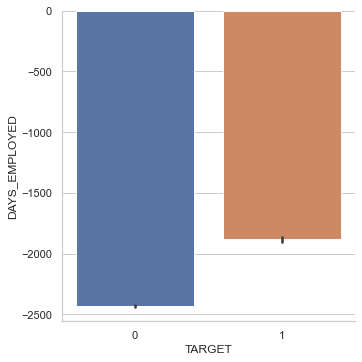

In [53]:
sns.catplot(x="TARGET", y="DAYS_EMPLOYED",kind="bar", data=moYappTrain)

# une première modélisation rapide

In [54]:
moYappTrain = moYappTrain[moYappTrain["AMT_ANNUITY"].notna()]

In [55]:
col = colNul(moYappTrain, 0)

        SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0     

In [56]:
col

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUM

In [57]:
Description('ORGANIZATION_TYPE')

['Type of organization where client works']
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


40    Type of organization where client works
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [58]:
moYappTrain_0 = moYappTrain[col].copy()

In [59]:
moYappTrain_0.shape

(307499, 58)

# Logistic regression

In [60]:
X = moYappTrain_0[['annuitySURrevenu','DAYS_EMPLOYED','AMT_INCOME_TOTAL', 'AMT_CREDIT']]
y = moYappTrain_0[['TARGET']]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

In [62]:
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

In [63]:
print(clf_logistic.coef_)

[[-2.29272836e-08  4.12914318e-04 -6.19048802e-06 -9.26809628e-07]]


In [64]:
clf_logistic.predict_proba(X_test)

array([[0.83557555, 0.16442445],
       [0.86068625, 0.13931375],
       [0.87719867, 0.12280133],
       ...,
       [0.95834242, 0.04165758],
       [0.90358596, 0.09641404],
       [0.91307863, 0.08692137]])

In [65]:
prob_default = pd.DataFrame(clf_logistic.predict_proba(X_test))[1][:]

In [66]:
clf_logistic.score(X_test, y_test)

0.9192628726287263

In [67]:
prob_default

0        0.164424
1        0.139314
2        0.122801
3        0.063209
4        0.047695
           ...   
92245    0.169479
92246    0.159134
92247    0.041658
92248    0.096414
92249    0.086921
Name: 1, Length: 92250, dtype: float64

# ROC

In [68]:
# fallout, sensitivity, thresholds = metrics.roc_curve(y_test, prob_default)
# plt.plot(fallout, sensitivity, color = 'darkorange')

In [69]:
preds_df = pd.DataFrame(np.array(prob_default), columns = ['prob_default'])

In [70]:
prob_default

0        0.164424
1        0.139314
2        0.122801
3        0.063209
4        0.047695
           ...   
92245    0.169479
92246    0.159134
92247    0.041658
92248    0.096414
92249    0.086921
Name: 1, Length: 92250, dtype: float64

In [71]:
preds_df

,prob_default
0,0.164424
1,0.139314
2,0.122801
3,0.063209
4,0.047695
...,...
92245,0.169479
92246,0.159134
92247,0.041658
92248,0.096414


In [72]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

In [73]:
print(preds_df['loan_status'].value_counts())

0    92250
Name: loan_status, dtype: int64


In [74]:
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.92      1.00      0.96     84802
     Default       0.00      0.00      0.00      7448

    accuracy                           0.92     92250
   macro avg       0.46      0.50      0.48     92250
weighted avg       0.85      0.92      0.88     92250



In [75]:
print(precision_recall_fscore_support(y_test,preds_df['loan_status']))

(array([0.91926287, 0.        ]), array([1., 0.]), array([0.95793326, 0.        ]), array([84802,  7448]))


In [76]:
print(precision_recall_fscore_support(y_test,preds_df['loan_status'])[:2])

(array([0.91926287, 0.        ]), array([1., 0.]))


0.9192628726287263


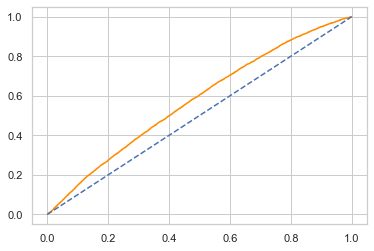

In [77]:

preds = clf_logistic.predict_proba(X_test)

print(clf_logistic.score(X_test, y_test))


prob_default = preds[:, 1]
fallout, sensitivity, thresholds = metrics.roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()


auc = metrics.roc_auc_score(y_test, prob_default)

# Matrice de confusion

# seuil 0.5

In [78]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)
print(metrics.confusion_matrix(y_test,preds_df['loan_status']))

[[84802     0]
 [ 7448     0]]


# seuil 0.4

In [79]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)
print(metrics.confusion_matrix(y_test,preds_df['loan_status']))

[[84796     6]
 [ 7447     1]]


# coût

In [80]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

In [81]:
num_defaults = preds_df['loan_status'].value_counts()[1]

In [82]:
num_defaults

7

In [83]:
default_recall = metrics.precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

In [84]:
print(moYappTrain_0["AMT_CREDIT"].mean()* num_defaults * (1 - default_recall))

4191261.6254111845


# idéal

In [85]:
thresh = [0.2, 0.225,0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65]

In [86]:
def_recalls = []
nondef_recalls = []
acc = []

In [87]:
for i in thresh:
    preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > i else 0)
    acc.append(metrics.accuracy_score(y_test, preds_df['loan_status']))
    def_recalls.append(metrics.precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1])
    nondef_recalls.append(metrics.precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][0])

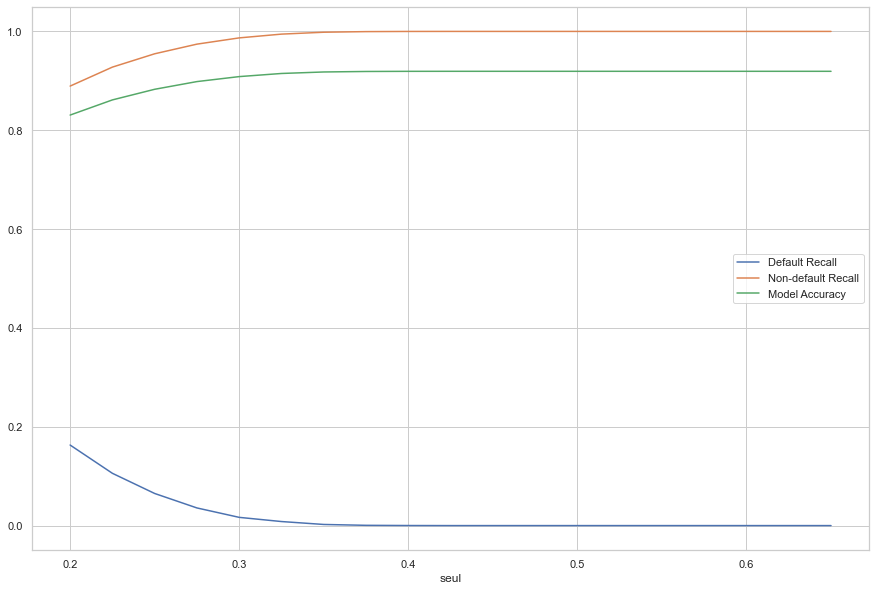

In [88]:
plt.figure(figsize=(15,10))
plt.plot(thresh, def_recalls)
plt.plot(thresh, nondef_recalls)
plt.plot(thresh, acc)
plt.xlabel("seul")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

# XGBoost

In [89]:
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

[16:08:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [90]:
gbt_preds = clf_gbt.predict_proba(X_test)

In [91]:
gbt_PD = pd.DataFrame(gbt_preds)[1][:]

In [92]:
gbt_PD

0        0.061160
1        0.052071
2        0.068620
3        0.047144
4        0.078225
           ...   
92245    0.025584
92246    0.171148
92247    0.064648
92248    0.115024
92249    0.052897
Name: 1, Length: 92250, dtype: float32

In [93]:
prob_default

array([0.16442445, 0.13931375, 0.12280133, ..., 0.04165758, 0.09641404,
       0.08692137])

In [94]:
portfolio = pd.concat([preds_df["prob_default"].reset_index(),gbt_PD.reset_index(),
                       X_test["AMT_CREDIT"].reset_index()], axis=1)

In [95]:
portfolio

,index,prob_default,index,1,index,AMT_CREDIT
0,0,0.164424,0,0.061160,72101,675000.0
1,1,0.139314,1,0.052071,42806,301464.0
2,2,0.122801,2,0.068620,176570,765000.0
3,3,0.063209,3,0.047144,142498,945000.0
4,4,0.047695,4,0.078225,235749,1288350.0
...,...,...,...,...,...,...
92245,92245,0.169479,92245,0.025584,84038,81549.0
92246,92246,0.159134,92246,0.171148,284890,310500.0
92247,92247,0.041658,92247,0.064648,71398,517788.0
92248,92248,0.096414,92248,0.115024,97980,417024.0


In [96]:
portfolio.drop('index', axis=1, inplace=True)

In [97]:
portfolio

,prob_default,1,AMT_CREDIT
0,0.164424,0.061160,675000.0
1,0.139314,0.052071,301464.0
2,0.122801,0.068620,765000.0
3,0.063209,0.047144,945000.0
4,0.047695,0.078225,1288350.0
...,...,...,...
92245,0.169479,0.025584,81549.0
92246,0.159134,0.171148,310500.0
92247,0.041658,0.064648,517788.0
92248,0.096414,0.115024,417024.0


In [98]:
portfolio['gbt_expected_loss'] = portfolio[1] *  portfolio['AMT_CREDIT']
portfolio['lr_expected_loss'] = portfolio['prob_default'] * portfolio['AMT_CREDIT']

In [99]:
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss'] ))
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

LR expected loss:  4132939704.029415
GBT expected loss:  4141976000.0


# Report

In [100]:
gbt_preds = clf_gbt.predict(X_test)

In [101]:
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.92      1.00      0.96     84802
     Default       0.00      0.00      0.00      7448

    accuracy                           0.92     92250
   macro avg       0.46      0.50      0.48     92250
weighted avg       0.85      0.92      0.88     92250



# Quelle colonne est importante

In [102]:
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

{'DAYS_EMPLOYED': 1116, 'AMT_CREDIT': 1035, 'AMT_INCOME_TOTAL': 606, 'annuitySURrevenu': 1258}


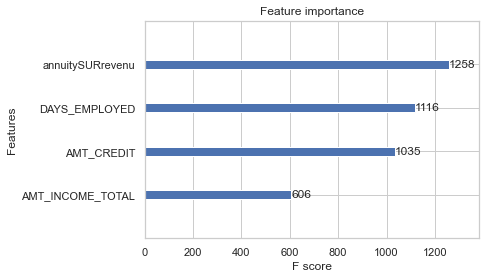

In [103]:
xgb.plot_importance(clf_gbt, importance_type = 'weight')
plt.show()

# Resampling

In [104]:
X_train

,annuitySURrevenu,DAYS_EMPLOYED,AMT_INCOME_TOTAL,AMT_CREDIT
161394,0.300500,-2384.169325,36000.0,269550.0
138486,0.061514,-297.000000,157500.0,111384.0
28931,0.193829,-447.000000,157500.0,942300.0
109555,0.098300,-2384.169325,270000.0,675000.0
26466,0.155520,-863.000000,225000.0,755190.0
...,...,...,...,...
280029,0.072283,-2384.169325,270000.0,663093.0
149420,0.088440,-1490.000000,112500.0,152820.0
175106,0.226743,-1888.000000,157500.0,1298655.0
105776,0.099143,-2384.169325,189000.0,472500.0


In [105]:
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)

In [106]:
count_nondefault, count_default = X_y_train['TARGET'].value_counts()

In [107]:
nondefaults = X_y_train[X_y_train['TARGET'] == 0]
defaults = X_y_train[X_y_train['TARGET'] == 1]

In [108]:
nondefaults_under = nondefaults.sample(count_default)

In [109]:
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [110]:
print(X_y_train_under['TARGET'].value_counts())

0    17377
1    17377
Name: TARGET, dtype: int64


In [111]:
X = X_y_train_under.drop('TARGET', axis=1)

In [112]:
X

,annuitySURrevenu,DAYS_EMPLOYED,AMT_INCOME_TOTAL,AMT_CREDIT
0,0.153000,-5678.000000,103500.0,273636.0
1,0.106300,-2384.169325,135000.0,254700.0
2,0.166875,-242.000000,108000.0,292500.0
3,0.117077,-2384.169325,58500.0,161730.0
4,0.073650,-1985.000000,180000.0,284400.0
...,...,...,...,...
17372,0.215164,-874.000000,247500.0,2013840.0
17373,0.141875,-243.000000,180000.0,545040.0
17374,0.150000,-525.000000,67500.0,202500.0
17375,0.333000,-1249.000000,90000.0,640080.0


In [113]:
y = X_y_train_under['TARGET']

In [114]:
clfR_gbt = xgb.XGBClassifier().fit(X, np.ravel(y))

[16:08:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [115]:
gbt2_preds = clfR_gbt.predict(X_test)

In [116]:
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.94      0.58      0.72     84802
     Default       0.11      0.59      0.18      7448

    accuracy                           0.58     92250
   macro avg       0.53      0.58      0.45     92250
weighted avg       0.87      0.58      0.68     92250



In [117]:
print(classification_report(y_test, gbt_preds, target_names=target_names))
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.92      1.00      0.96     84802
     Default       0.00      0.00      0.00      7448

    accuracy                           0.92     92250
   macro avg       0.46      0.50      0.48     92250
weighted avg       0.85      0.92      0.88     92250

              precision    recall  f1-score   support

 Non-Default       0.94      0.58      0.72     84802
     Default       0.11      0.59      0.18      7448

    accuracy                           0.58     92250
   macro avg       0.53      0.58      0.45     92250
weighted avg       0.87      0.58      0.68     92250



Le second modèle est plus performant si on mesure les pertes vue qu'il trouve plus "defaut"

# Matrice confusion

In [118]:
print(metrics.confusion_matrix(y_test,gbt_preds))
print(metrics.confusion_matrix(y_test,gbt2_preds))

[[84798     4]
 [ 7448     0]]
[[49320 35482]
 [ 3077  4371]]


In [119]:
print(metrics.roc_auc_score(y_test, gbt_preds))
print(metrics.roc_auc_score(y_test, gbt2_preds))

0.49997641565057427
0.5842295074739209


# Logistique

In [120]:
clfR_logistic = LogisticRegression(solver='lbfgs').fit(X, np.ravel(y))

In [121]:
log2_preds = clfR_logistic.predict(X_test)

In [122]:
print(classification_report(y_test, log2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.71      0.81     84802
     Default       0.10      0.38      0.16      7448

    accuracy                           0.69     92250
   macro avg       0.52      0.54      0.48     92250
weighted avg       0.86      0.69      0.75     92250



Evaluation des deux modèles

In [123]:
pd.DataFrame(clfR_logistic.predict_proba(X_test))[1]

0        0.486683
1        0.459904
2        0.522796
3        0.476596
4        0.522679
           ...   
92245    0.455132
92246    0.478549
92247    0.450989
92248    0.445421
92249    0.469143
Name: 1, Length: 92250, dtype: float64

In [124]:
pd.DataFrame(clfR_logistic.predict_proba(X_test))[1].values

array([0.48668292, 0.45990414, 0.52279631, ..., 0.45098909, 0.44542125,
       0.46914312])

In [125]:
preds_df_lr = pd.DataFrame(np.array(pd.concat([pd.DataFrame(clfR_logistic.predict_proba(X_test))[1], pd.Series(clfR_logistic.predict(X_test))], axis=1)), columns=["prob_defaut", "TARGET"])

In [126]:
preds_df_lr

,prob_defaut,TARGET
0,0.486683,0.0
1,0.459904,0.0
2,0.522796,1.0
3,0.476596,0.0
4,0.522679,1.0
...,...,...
92245,0.455132,0.0
92246,0.478549,0.0
92247,0.450989,0.0
92248,0.445421,0.0


In [127]:
X_test

,annuitySURrevenu,DAYS_EMPLOYED,AMT_INCOME_TOTAL,AMT_CREDIT
72101,0.333425,-1437.000000,65700.0,675000.0
42806,0.188450,-2384.169325,90000.0,301464.0
176570,0.166125,-346.000000,180000.0,765000.0
142498,0.297533,-2384.169325,135000.0,945000.0
235749,0.168000,-986.000000,225000.0,1288350.0
...,...,...,...,...
84038,0.094421,-2384.169325,85500.0,81549.0
284890,0.187840,-1648.000000,112500.0,310500.0
71398,0.097022,-3396.000000,202500.0,517788.0
97980,0.244050,-3134.000000,90000.0,417024.0


In [128]:
preds_df_gbt = pd.DataFrame(np.array(pd.concat([pd.DataFrame(clfR_gbt.predict_proba(X_test))[1], pd.Series(clfR_gbt.predict(X_test)), X_test['AMT_CREDIT'].reset_index(drop=True)], axis=1)), columns=["prob_defaut", "TARGET", "AMT_CREDIT"])

In [129]:
preds_df_gbt

,prob_defaut,TARGET,AMT_CREDIT
0,0.514635,1.0,675000.0
1,0.336990,0.0,301464.0
2,0.584801,1.0,765000.0
3,0.293373,0.0,945000.0
4,0.473377,0.0,1288350.0
...,...,...,...
92245,0.282903,0.0,81549.0
92246,0.697877,1.0,310500.0
92247,0.433135,0.0,517788.0
92248,0.589529,1.0,417024.0


In [130]:
print(classification_report(y_test, preds_df_lr['TARGET'], target_names=target_names))


print(classification_report(y_test, preds_df_gbt['TARGET'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.71      0.81     84802
     Default       0.10      0.38      0.16      7448

    accuracy                           0.69     92250
   macro avg       0.52      0.54      0.48     92250
weighted avg       0.86      0.69      0.75     92250

              precision    recall  f1-score   support

 Non-Default       0.94      0.58      0.72     84802
     Default       0.11      0.59      0.18      7448

    accuracy                           0.58     92250
   macro avg       0.53      0.58      0.45     92250
weighted avg       0.87      0.58      0.68     92250



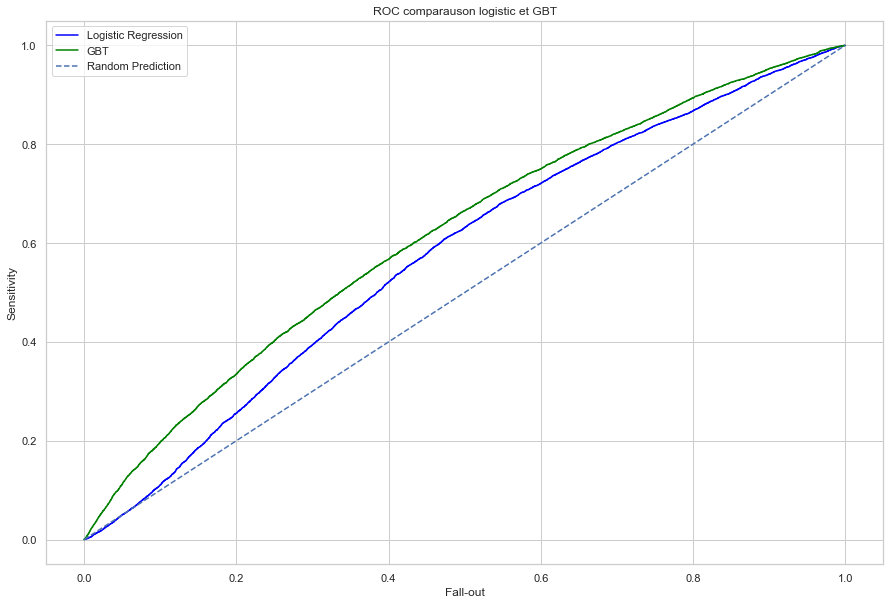

In [131]:

fallout_lr, sensitivity_lr, thresholds_lr = metrics.roc_curve(y_test, preds_df_lr["prob_defaut"])
fallout_gbt, sensitivity_gbt, thresholds_gbt = metrics.roc_curve(y_test, preds_df_gbt["prob_defaut"])

plt.figure(figsize=(15,10))
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC comparauson logistic et GBT")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

Taux d'acceptiation

In [132]:
# Check the statistics of the probabilities of default
print(preds_df_gbt["prob_defaut"].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(preds_df_gbt["prob_defaut"], 0.85)

# Apply acceptance rate threshold
preds_df_gbt['pred_TARGET'] = preds_df_gbt["prob_defaut"].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(preds_df_gbt['pred_TARGET'].value_counts())

count    92250.000000
mean         0.476432
std          0.141191
min          0.010312
25%          0.382705
50%          0.474769
75%          0.575595
max          0.969234
Name: prob_defaut, dtype: float64
0    78412
1    13838
Name: pred_TARGET, dtype: int64


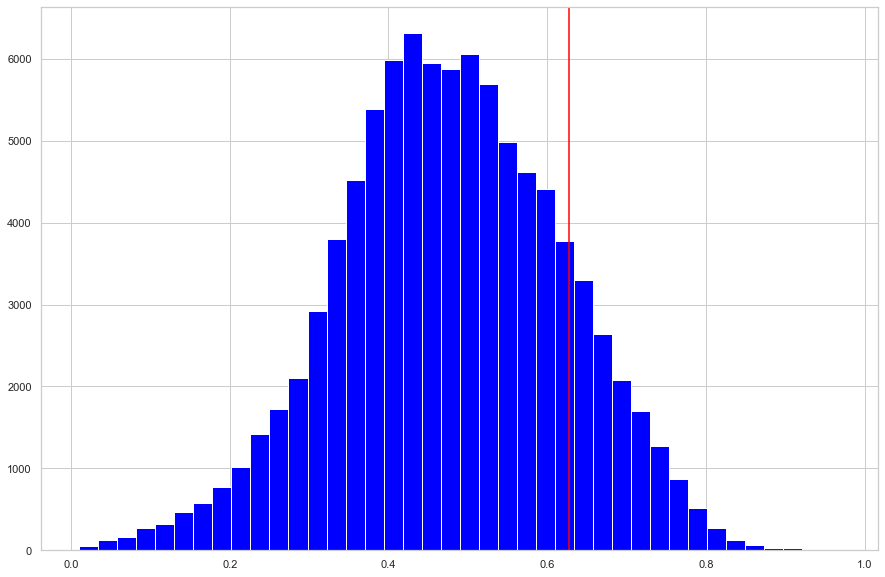

In [133]:
plt.figure(figsize=(15,10))
plt.hist(preds_df_gbt["prob_defaut"], color = 'blue', bins = 40)

threshold = np.quantile(preds_df_gbt["prob_defaut"], 0.85)

plt.axvline(x = threshold, color = 'red')
plt.show()

In [134]:
preds_df_gbt['pred_loan_status'] = preds_df_gbt["prob_defaut"].apply(lambda x: 1 if x > threshold else 0)

In [135]:
np.sum(preds_df_gbt['TARGET'])

39853.0

In [136]:
#preds_df_gbt['pred_loan_status'] = preds_df_gbt["prob_defaut"].apply(lambda x: 1 if x > 0.5 else 0)

In [137]:
accepted_loans = preds_df_gbt[preds_df_gbt['pred_loan_status'] == 0]

In [138]:
print(np.sum(accepted_loans['TARGET']) / accepted_loans['TARGET'].count())

0.331773197979901


In [139]:
accepted_loans

,prob_defaut,TARGET,AMT_CREDIT,pred_TARGET,pred_loan_status
0,0.514635,1.0,675000.0,0,0
1,0.336990,0.0,301464.0,0,0
2,0.584801,1.0,765000.0,0,0
3,0.293373,0.0,945000.0,0,0
4,0.473377,0.0,1288350.0,0,0
...,...,...,...,...,...
92244,0.383695,0.0,1125000.0,0,0
92245,0.282903,0.0,81549.0,0,0
92247,0.433135,0.0,517788.0,0,0
92248,0.589529,1.0,417024.0,0,0


# Impact du mauvais taux

In [140]:
print(preds_df_gbt['AMT_CREDIT'].describe())

# Store the average loan amount
avg_loan = np.mean(preds_df_gbt['AMT_CREDIT'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df_gbt['TARGET'],
                 preds_df_gbt['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

count    9.225000e+04
mean     5.983483e+05
std      4.020223e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.124465e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64
pred_loan_status                  0                 1
TARGET                                               
$0.00            $31,351,656,530.06             $0.00
$1.00            $15,566,031,349.69 $8,279,943,948.38


exemple 85%

In [141]:
pd.reset_option('^display.', silent=True)

In [142]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 
                0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

In [143]:
thresholds = []
bad_rates = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df_gbt['prob_defaut'], rate).round(3)
    
    thresholds.append(np.quantile(preds_df_gbt['prob_defaut'], rate).round(3))
    
    preds_df_gbt['pred_loan_status'] = preds_df_gbt['prob_defaut'].apply(lambda x: 1 if x > thresh else 0)
    
    accepted_loans = preds_df_gbt[preds_df_gbt['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['TARGET']) / len(accepted_loans['TARGET'])).round(3))

In [144]:
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Taux acceptation','Threshold','Bad Rate'])

In [145]:
strat_df

,Taux acceptation,Threshold,Bad Rate
0,1.00,0.969,0.432
1,0.95,0.710,0.402
2,0.90,0.661,0.369
3,0.85,0.628,0.332
4,0.80,0.600,0.290
5,0.75,0.576,0.243
6,0.70,0.552,0.189
7,0.65,0.531,0.126
8,0.60,0.512,0.054
9,0.55,0.493,0.000


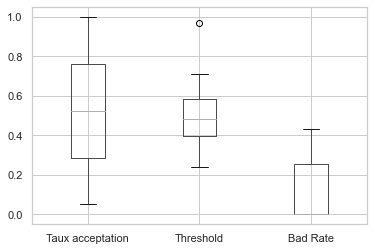

In [146]:
strat_df.boxplot()
plt.show()

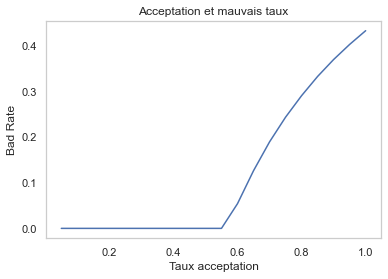

In [147]:
plt.plot(strat_df['Taux acceptation'], strat_df['Bad Rate'])
plt.xlabel('Taux acceptation')
plt.ylabel('Bad Rate')
plt.title('Acceptation et mauvais taux')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [148]:
np.sum(preds_df_gbt["prob_defaut"] < np.quantile(preds_df_gbt["prob_defaut"], 1))

92249

In [149]:
strat_df['Avg'] = avg_loan

In [150]:
nb_accept = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df_gbt['prob_defaut'], rate).round(3)
    
    nb_accept.append(np.sum(preds_df_gbt["prob_defaut"] < thresh))
    
    

In [151]:
strat_df['nb_accept'] = nb_accept

In [152]:
strat_df

,Taux acceptation,Threshold,Bad Rate,Avg,nb_accept
0,1.00,0.969,0.432,598348.3125,92249
1,0.95,0.710,0.402,598348.3125,87683
2,0.90,0.661,0.369,598348.3125,83063
3,0.85,0.628,0.332,598348.3125,78474
4,0.80,0.600,0.290,598348.3125,73840
5,0.75,0.576,0.243,598348.3125,69259
6,0.70,0.552,0.189,598348.3125,64620
7,0.65,0.531,0.126,598348.3125,59972
8,0.60,0.512,0.054,598348.3125,55390
9,0.55,0.493,0.000,598348.3125,50622


In [153]:
strat_df['estimation'] = strat_df['nb_accept']*(1-strat_df['Bad Rate'])*strat_df['Avg'] - strat_df['nb_accept']*strat_df['Bad Rate']*strat_df['Avg']

In [154]:
strat_df

,Taux acceptation,Threshold,Bad Rate,Avg,nb_accept,estimation
0,1.00,0.969,0.432,598348.3125,92249,7.506795e+09
1,0.95,0.710,0.402,598348.3125,87683,1.028313e+10
2,0.90,0.661,0.369,598348.3125,83063,1.302156e+10
3,0.85,0.628,0.332,598348.3125,78474,1.577681e+10
4,0.80,0.600,0.290,598348.3125,73840,1.855646e+10
5,0.75,0.576,0.243,598348.3125,69259,2.130068e+10
6,0.70,0.552,0.189,598348.3125,64620,2.404980e+10
7,0.65,0.531,0.126,598348.3125,59972,2.684134e+10
8,0.60,0.512,0.054,598348.3125,55390,2.956312e+10
9,0.55,0.493,0.000,598348.3125,50622,3.028959e+10


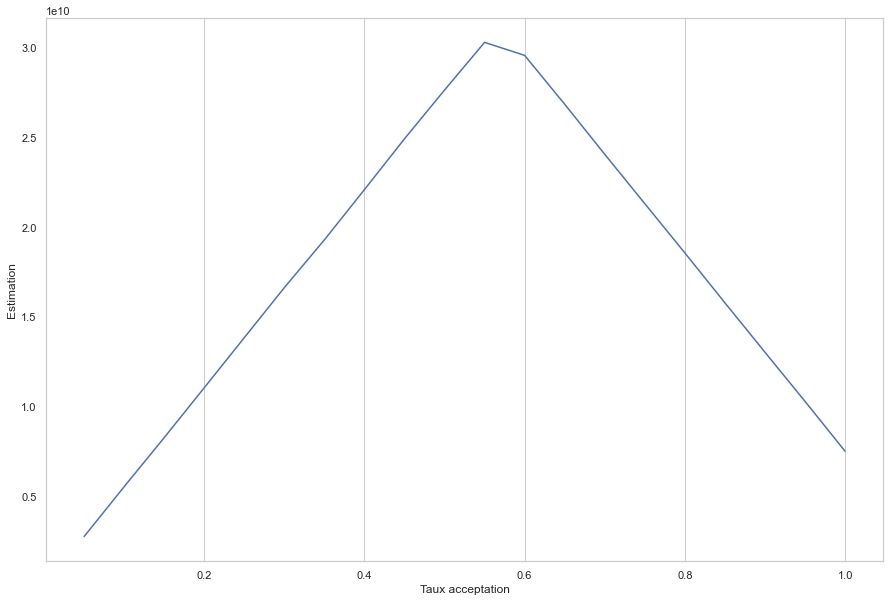

In [155]:
plt.figure(figsize=(15,10))
plt.plot(strat_df['Taux acceptation'],strat_df['estimation'])
plt.title('')
plt.xlabel('Taux acceptation')
plt.ylabel('Estimation')
plt.axes().yaxis.grid()
plt.show()

In [156]:
# moYappTrain_0['AMT_CREDIT'].describe()

In [157]:
print(strat_df.loc[strat_df['estimation'] == np.max(strat_df['estimation'])])

   Taux acceptation  Threshold  Bad Rate          Avg  nb_accept    estimation
9              0.55      0.493       0.0  598348.3125      50622  3.028959e+10


# Perte total

In [158]:
preds_df_gbt['perte'] = preds_df_gbt['prob_defaut'] * preds_df_gbt['AMT_CREDIT']

In [159]:
tot_perte = round(np.sum(preds_df_gbt['perte']),2)

In [160]:
tot_perte

25307652000.0

In [161]:
dire[18]

'How many days before the application the person started current employment'

In [162]:
bureauBal

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [163]:
bureauBal["MONTHS_BALANCE"].describe()

count    2.729992e+07
mean    -3.074169e+01
std      2.386451e+01
min     -9.600000e+01
25%     -4.600000e+01
50%     -2.500000e+01
75%     -1.100000e+01
max      0.000000e+00
Name: MONTHS_BALANCE, dtype: float64

In [164]:
creditCardBal

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000000,45000,NaN,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000000,45000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.968750,585000,270000.0,270000.0,0.0,0.0,2250.000000,...,273093.968750,273093.968750,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000000,450000,NaN,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,NaN,0,NaN,NaN,0.0,Active,0,0


In [165]:
homeCredit

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [166]:
homeCredit.loc[homeCredit["Row"]=="STATUS",]["Description"].values

['Status of Credit Bureau loan during the month...]
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [167]:
installmentsP

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500000,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500000,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.433594,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500000,NaN


In [168]:
Description("NUM_INSTALMENT_NUMBER")

['On which installment we observe payment']
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


214    On which installment we observe payment
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [169]:
POS_CASH_B

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [170]:
previous_Apps

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290039,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855469,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.519531,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [171]:
sample_sub

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5
...,...,...
48739,456221,0.5
48740,456222,0.5
48741,456223,0.5
48742,456224,0.5


In [172]:
appTrain

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,credSURrevenu,annuitySURrevenu
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.007889,0.121978
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.790750,0.132217
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.100000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.316167,0.219900
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.222222,0.179963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.617143,0.174971
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.743750,0.166688
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,1.0,0.0,0.0,1.0,0.0,1.0,4.429176,0.195941
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.164368,0.118158


In [173]:
Description("TARGET")

['Target variable (1 - client with payment diff...]
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


1    Target variable (1 - client with payment diffi...
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [174]:
appTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 124 entries, SK_ID_CURR to annuitySURrevenu
dtypes: category(16), float16(61), float32(6), int16(2), int32(2), int8(37)
memory usage: 61.9 MB


In [175]:
appTrain.isna().sum().sort_values()

SK_ID_CURR                         0
WEEKDAY_APPR_PROCESS_START         0
HOUR_APPR_PROCESS_START            0
REG_REGION_NOT_LIVE_REGION         0
REG_REGION_NOT_WORK_REGION         0
                               ...  
NONLIVINGAPARTMENTS_MODE      213514
NONLIVINGAPARTMENTS_AVG       213514
COMMONAREA_MEDI               214865
COMMONAREA_MODE               214865
COMMONAREA_AVG                214865
Length: 124, dtype: int64

In [176]:
appTrain.isna().sum().value_counts()

0         56
41519      6
1021       4
208642     3
204488     3
182590     3
153020     3
213514     3
214865     3
163891     3
169682     3
154828     3
179943     3
154350     3
156061     3
210199     3
150007     3
12         2
148431     1
1          1
145755     1
96391      1
173378     1
1292       1
156341     1
202929     1
2          1
60965      1
210295     1
278        1
660        1
154297     1
dtype: int64

In [177]:
Description("AMT_REQ_CREDIT_BUREAU_WEEK")

['Number of enquiries to Credit Bureau about th...]
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


118    Number of enquiries to Credit Bureau about the...
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [178]:
appTrain.loc[:,(appTrain.isna().sum() == 12).values]

,AMT_ANNUITY,annuitySURrevenu
0,24700.5,0.121978
1,35698.5,0.132217
2,6750.0,0.100000
3,29686.5,0.219900
4,21865.5,0.179963
...,...,...
307506,27558.0,0.174971
307507,12001.5,0.166688
307508,29979.0,0.195941
307509,20205.0,0.118158


In [179]:
Description("AMT_ANNUITY")

['Loan annuity', 'Annuity of the Credit Bureau credit', 'Annuity of previous application']
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


9                             Loan annuity
138    Annuity of the Credit Bureau credit
176        Annuity of previous application
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [180]:
appTrain["AMT_ANNUITY"].describe()

count    307499.000000
mean      27110.958984
std       14493.233398
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

In [181]:
appTrain.loc[appTrain["AMT_ANNUITY"]==258025.5,]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,credSURrevenu,annuitySURrevenu
17948,120926,0,Cash loans,M,Y,N,2,783000.0,4050000.0,258025.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,5.172414,0.329534


In [182]:
Description("AMT_GOODS_PRICE")

['For consumer loans it is the price of the goo..., 'Goods price of good that client asked for (if...]
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


10     For consumer loans it is the price of the good...
180    Goods price of good that client asked for (if ...
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [183]:
appTrain

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,credSURrevenu,annuitySURrevenu
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.007889,0.121978
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.790750,0.132217
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.100000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.316167,0.219900
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.222222,0.179963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.617143,0.174971
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.743750,0.166688
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,1.0,0.0,0.0,1.0,0.0,1.0,4.429176,0.195941
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.164368,0.118158


In [185]:
(appTrain["AMT_CREDIT"]-appTrain["AMT_GOODS_PRICE"]).describe()

count    307233.000000
mean      60931.359375
std       70513.570312
min     -765000.000000
25%           0.000000
50%       39204.000000
75%       99972.000000
max      540000.000000
dtype: float64

In [186]:
appTrain.loc[(appTrain["AMT_CREDIT"]-appTrain["AMT_GOODS_PRICE"]) == -765000,]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,credSURrevenu,annuitySURrevenu
171196,298406,0,Revolving loans,F,N,N,0,85500.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,5.0,1.578947,0.078947
211250,344802,0,Revolving loans,F,N,Y,3,90000.0,135000.0,6750.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,1.500000,0.075000


In [187]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,9.132300e+04,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,2.250000e+05,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,4.643235e+05,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,9.000000e+04,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2.700000e+06,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,1.125000e+04,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2432.0,-2492.0,5476.5,0,3.813084e+04,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,1.557000e+04,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,3.600000e+04,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [188]:
Description("AMT_CREDIT_SUM_OVERDUE")

['Current amount overdue on Credit Bureau credit']
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


135    Current amount overdue on Credit Bureau credit
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [189]:
POS_CASH_B

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [190]:
Description("CREDIT_ACTIVE")

['Status of the Credit Bureau (CB) reported cre...]
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


124    Status of the Credit Bureau (CB) reported credits
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

In [191]:
POS_CASH_B["CNT_INSTALMENT"].describe()

count    9975287.0
mean           NaN
std            0.0
min            1.0
25%           10.0
50%           12.0
75%           24.0
max           92.0
Name: CNT_INSTALMENT, dtype: float64

In [192]:
bureauBal

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [193]:
bureauBal["MONTHS_BALANCE"].describe()

count    2.729992e+07
mean    -3.074169e+01
std      2.386451e+01
min     -9.600000e+01
25%     -4.600000e+01
50%     -2.500000e+01
75%     -1.100000e+01
max      0.000000e+00
Name: MONTHS_BALANCE, dtype: float64